In [5]:
import pandas as pd
import numpy as np
import loompy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import matplotlib as mpl
import imp
import sys

# here we load the .py files as modules:
#sys.path.append('/home/bojk/Data/minimeta_pyfiles/') #my linux
sys.path.append('/Users/bojk/Google Drive/QuakeLab/minimeta_pyfiles/') #my mac
import northstar_analysis as sam
import northstar_sankey as sank
import northstar_dotplot as sdot
import get_timestamp as time

In [2]:
# load data
# Bob Jones Tumor Pancreas dataset (to be annotated)
TuPa_count_path = '../leidenalg/Datasets/TuPaMetaDataDivya/CuratedTumorCountTable.csv'
TuPa_counttable = pd.read_csv(TuPa_count_path,index_col=0)
TuPa_meta = pd.read_csv('../leidenalg/Datasets/TuPaMetaDataDivya/CuratedTumorMetaData.csv',sep=',',index_col=0)
tsne_coords  = pd.read_csv('../leidenalg/Datasets/TuPaMetaDataDivya/CuratedTumorTSNECoordinates.csv',index_col=0)
TuPa_meta = TuPa_meta.join(tsne_coords)

# switch index from ENSG number to gene name 
translate = pd.read_csv('../leidenalg/Datasets/mart_export.txt',sep='\t')
lut = dict(zip(translate['Gene stable ID'],translate['Gene name']))
TuPa_counttable.rename(index=lut,columns=str,inplace=True)
#  Pancreas data (adult aging to be used as atlas)
AA_count_path = '../leidenalg/Datasets/AdultAgingPancForCIRM/AdultAgeingCountTable.csv'
AA_counttable = pd.read_csv(AA_count_path,index_col=0)
AA_meta = pd.read_csv('../leidenalg/Datasets/AdultAgingPancForCIRM/pancreas_adult_annotation_table.csv')
AA_meta['idx'] = 'X'+AA_meta['c1_chip_id'].astype(str)+'.'+AA_meta['capture_position']
AA_meta.set_index('idx',inplace=True)

AAtsne = pd.read_csv('../leidenalg/Datasets/AdultAgingPancForCIRM/AdultAgeingTSNETable.csv',sep=',')
AAtsne.set_index(AAtsne['Unnamed: 0'].str[1:],inplace=True)
AAtsne.index = 'X'+AAtsne.index
AAtsne.rename(index=str,columns={'Unnamed: 1': 'Dim1','Unnamed: 2':'Dim2'},inplace=True)
AA_meta = AA_meta.join(AAtsne[['Dim1','Dim2','celltypes']],how='inner')
AA_meta.dropna(how='all',axis=1,inplace=True)

# get rid of tumor samples with extremely low cell count (low quality)
print(len(TuPa_meta))
dropout_tumors = TuPa_meta['Tumor'].value_counts()[(TuPa_meta['Tumor'].value_counts()<10)].index
dropout_cells = TuPa_meta[TuPa_meta['Tumor'].isin(dropout_tumors)].index
TuPa_counttable.drop(dropout_cells,axis=1,inplace=True)
TuPa_meta = TuPa_meta[~TuPa_meta['Tumor'].isin(dropout_tumors)]
print(len(TuPa_meta))

TuPa_meta['celltypes'] = np.nan
#TuPa_meta.rename(index=str, columns={'annotation':'celltypes'},inplace=True) # this is when annotations are present

AA_newmeta = AA_meta[AA_meta['celltypes']!='unsure'].copy()
len(AA_newmeta)

1807
1795


2280

In [9]:
sa = sam.northstar.AtlasFetcher()
AT = sa.list_atlases()
AT[AT['Species'].str.contains('Homo')]

,Species,Technology,Tissue,Ages,Reference,URL_average,URL_subsample,Notes
Name,,,,,,,,
Darmanis_2015,Homo sapiens,SmartSeq2,brain,"fetal,adult",Darmanis et al. PNAS (2015),https://github.com/iosonofabio/atlas_averages/...,https://github.com/iosonofabio/atlas_averages/...,NaN
Darmanis_2015_nofetal,Homo sapiens,SmartSeq2,brain,adult,Darmanis et al. PNAS (2015),https://github.com/iosonofabio/atlas_averages/...,https://github.com/iosonofabio/atlas_averages/...,no fetal data
Enge_2017,Homo sapiens,SmartSeq2,pancreas,"fetal,adult",Enge et al. Cell (2017),https://github.com/iosonofabio/atlas_averages/...,https://github.com/iosonofabio/atlas_averages/...,NaN
Stitzel_2016,Homo sapiens,Fluidigm C1,pancreas,adult,Stitzel et al. Genome Research (2016),https://github.com/iosonofabio/atlas_averages/...,https://github.com/iosonofabio/atlas_averages/...,NaN
Baron_2016,Homo sapiens,InDrop,pancreas,adult,Baron et al. Cell Systems (2016),https://github.com/iosonofabio/atlas_averages/...,https://github.com/iosonofabio/atlas_averages/...,NaN
Zanini_2018,Homo sapiens,SmartSeq2,blood,adult,"Zanini, Robinson et al. PNAS (2018)",https://github.com/iosonofabio/atlas_averages/...,https://github.com/iosonofabio/atlas_averages/...,NaN
Croote_2018,Homo sapiens,SmartSeq2,blood,children,Croote et al. Science (2018),https://github.com/iosonofabio/atlas_averages/...,https://github.com/iosonofabio/atlas_averages/...,NaN
Aizaran_2019,Homo sapiens,mCEL-Seq2,liver,adult,Aizaran et al. Nature (2019),https://github.com/iosonofabio/atlas_averages/...,https://github.com/iosonofabio/atlas_averages/...,NaN


In [115]:
atlases = ['Stitzel_2016','Baron_2016','Zanini_2018']
atlas = sa.fetch_multiple_atlases(atlases)
atlas_counttable = atlas['counts']
atlas_metadata = pd.DataFrame(atlas['number_of_cells']).rename(index=str,columns={0:'number_of_cells'})
atlas_metadata['celltypes'] = atlas_metadata.index
date = time.datenum_complete()
date

'20190821171330'

# sub-tSNE on pancreas endocrine cells

In [ ]:
savedir = '../leidenalg/Datasets/Pancreas/'
AA_manual_meta = pd.read_csv(savedir+'manual_annotation_EngePancreas.csv').set_index('Unnamed: 0')

In [85]:
(AA_manual_meta['celltypes']==AA_manual_meta['man_annot2']).all()

True

### first annotate as in 20180809_Pancreas_SemiAnnotate_curated_unbiasedApproach.ipynb

In [160]:
atlasgenes = 60
atlasweights = 20

keys = ['cell type column','number of features cell type','number of features new data'
        ,'weights_atlas_cells','timestamp','savedir']
values = ['celltypes',atlasgenes,10,atlasweights,date,savedir]
kwds = dict(zip(keys,values))
matrix,weights, AA_manual_meta,TuPa_meta = sam.normmerge_twoCounttables(AA_counttable,
                                                                             AA_manual_meta, TuPa_counttable, TuPa_meta, **kwds)
matrix_feature_selected = sam.feature_select(matrix.dropna(how='all',axis=1),AA_manual_meta,**kwds)

-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5', 'ERCC-00002', 'ERCC-00003', 'ERCC-00004', 'ERCC-00009', 'ERCC-00012', 'ERCC-00013', 'ERCC-00014', 'ERCC-00016', 'ERCC-00017', 'ERCC-00019', 'ERCC-00022', 'ERCC-00024', 'ERCC-00025', 'ERCC-00028', 'ERCC-00031', 'ERCC-00033', 'ERCC-00034', 'ERCC-00035', 'ERCC-00039', 'ERCC-00040', 'ERCC-00041', 'ERCC-00042', 'ERCC-00043', 'ERCC-00044', 'ERCC-00046', 'ERCC-00048', 'ERCC-00051', 'ERCC-00053', 'ERCC-00054', 'ERCC-00057', 'ERCC-00058', 'ERCC-00059', 'ERCC-00060', 'ERCC-00061', 'ERCC-00062', 'ERCC-00067', 'ERCC-00069', 'ERCC-00071', 'ERCC-00073', 'ERCC-00074', 'ERCC-00075', 'ERCC-00076', 'ERCC-00077', 'ERCC-00078', 'ERCC-00079', 'ERCC-00081', 'ERCC-00083', 'ERCC-00084', 'ERCC-00085', 'ERCC-00086', 'ERCC-00092', 'ERCC-00095', 'ERCC-00096', 'ERCC-00097', 'ERCC-00098', 'ERCC-00099', 'ERCC-00104', 'ERCC-00108', 'ERCC-00109', 'ERCC-00111', 'ERCC-00112', 'ERCC-00113', 'ERCC-00116', 'ERCC-00117', 'ERCC-00

-------------------------------------------
Cell types in atlas:
['acinar' 'alpha' 'beta' 'delta' 'ductal' 'endothelial' 'epsilon' 'gamma'
 'mesenchymal' 'stellate']
-------------------------------------------
Cell types in new data:
[nan]
-------------------------------------------
-------------------------------------------
Selected number of genes from atlas:
600
-------------------------------------------
Selected number of genes from new cells:
10
-------------------------------------------
Combined total of selected genes:
603
-------------------------------------------


In [161]:
imp.reload(sam)
kwds['threshold_neigborhood'] = thresn = .8
kwds['n_pcs'] = n_pcs = 20 
kwds['resolution_parameter'] = respar = .015
kwds['self_edging'] = False
kwds['select_features']=False

tsnedf, class_numbers,class_labels,distmat = sam.semiAnnotate_to_pca_to_tsnedf(matrix_feature_selected,weights,AA_manual_meta,TuPa_meta,**kwds)

-------------------------------------------
performing UNweighted PCA
-------------------------------------------
perfoming tSNE
tSNE done.
-------------------------------------------


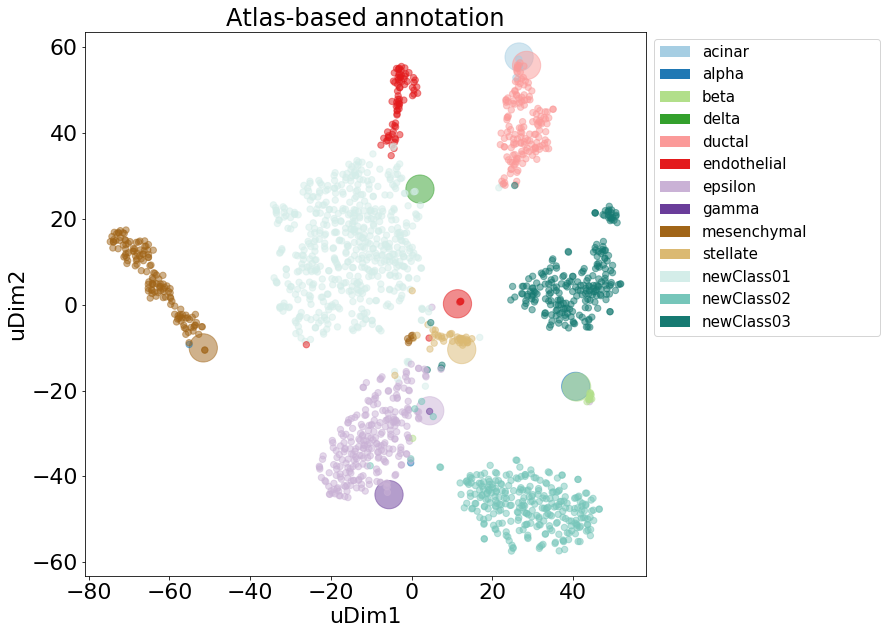

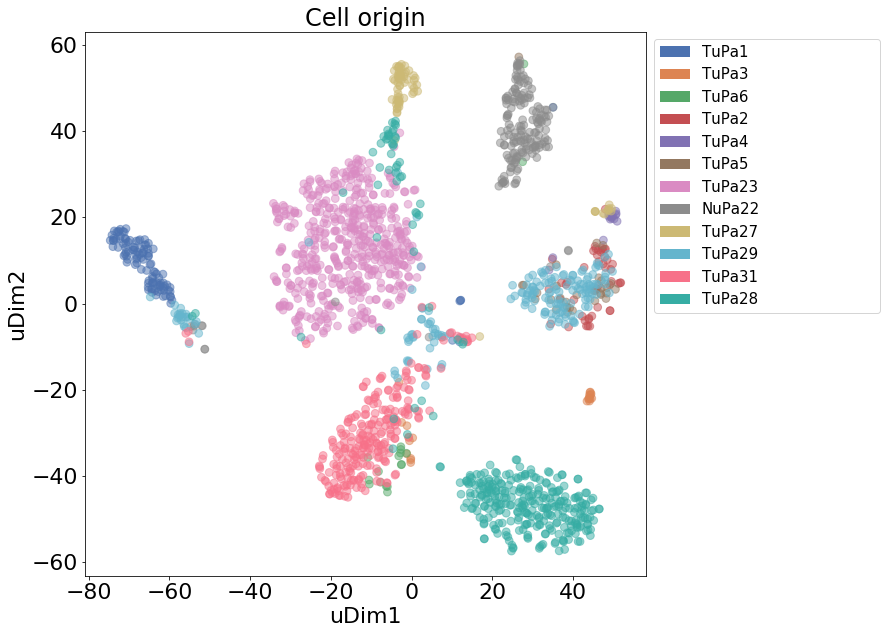

In [181]:
imp.reload(sam)
sam.plot_tsnes(tsnedf,class_numbers,class_labels,weights,TuPa_meta,**kwds)

In [10]:
cells_for_subclustering = tsnedf[(tsnedf['uDim1']>-30)&(tsnedf['uDim1']<5)&(tsnedf['uDim2']<-11)].index
cells_for_subclustering2 = tsnedf[(tsnedf['uDim1']>=5)&(tsnedf['uDim2']<-11)&((tsnedf['uDim2']>-30))].index

In [11]:
cells_for_subclustering  = list(cells_for_subclustering)+list(cells_for_subclustering2)

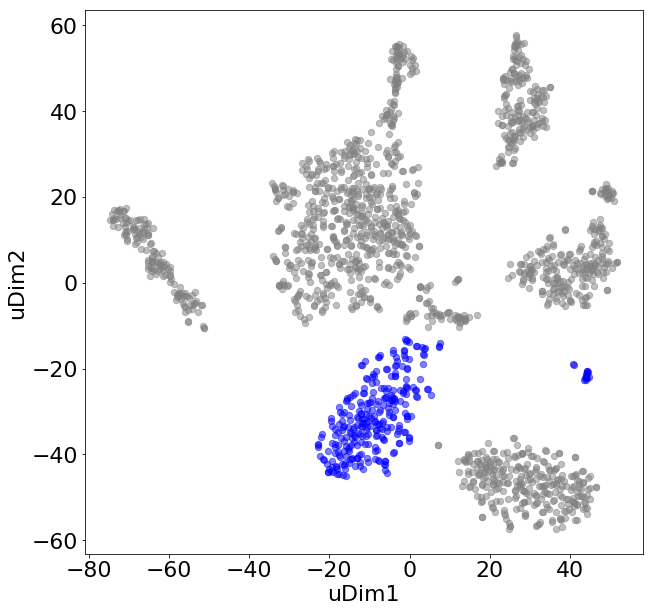

In [12]:
f,ax = plt.subplots(figsize=(10,10))
tsnedf[~tsnedf.index.isin(cells_for_subclustering)].plot.scatter('uDim1','uDim2',s=40
                    ,alpha=.5,color='gray',ax=ax)
tsnedf.loc[cells_for_subclustering].plot.scatter('uDim1','uDim2',s=40
                    ,alpha=.5,color='b',ax=ax)

In [13]:
endocrine_classes = ['alpha','beta','gamma','delta','epsilon']
endocrine_atlas_cells = AA_manual_meta[AA_manual_meta['celltypes'].isin(endocrine_classes)].index
endocrine_test_cells = [f for f in cells_for_subclustering if f not in endocrine_classes]

In [14]:
atlasgenes = 120
atlasweights = 20

keys = ['cell type column','number of features cell type','number of features new data'
        ,'weights_atlas_cells','timestamp','savedir']
values = ['celltypes',atlasgenes,40,atlasweights,date,savedir]
kwds = dict(zip(keys,values))
matrix,weights, AA_manual_meta_sub1,TuPa_meta_sub1 = sam.normmerge_twoCounttables(AA_counttable[endocrine_atlas_cells],
                                                                             AA_manual_meta.loc[endocrine_atlas_cells], 
                                                                             TuPa_counttable[endocrine_test_cells], 
                                                                             TuPa_meta.loc[endocrine_test_cells], **kwds)
matrix_feature_selected = sam.feature_select(matrix.dropna(how='all',axis=1),AA_manual_meta_sub1,**kwds)

-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5', 'ERCC-00002', 'ERCC-00003', 'ERCC-00004', 'ERCC-00009', 'ERCC-00012', 'ERCC-00013', 'ERCC-00014', 'ERCC-00016', 'ERCC-00017', 'ERCC-00019', 'ERCC-00022', 'ERCC-00024', 'ERCC-00025', 'ERCC-00028', 'ERCC-00031', 'ERCC-00033', 'ERCC-00034', 'ERCC-00035', 'ERCC-00039', 'ERCC-00040', 'ERCC-00041', 'ERCC-00042', 'ERCC-00043', 'ERCC-00044', 'ERCC-00046', 'ERCC-00048', 'ERCC-00051', 'ERCC-00053', 'ERCC-00054', 'ERCC-00057', 'ERCC-00058', 'ERCC-00059', 'ERCC-00060', 'ERCC-00061', 'ERCC-00062', 'ERCC-00067', 'ERCC-00069', 'ERCC-00071', 'ERCC-00073', 'ERCC-00074', 'ERCC-00075', 'ERCC-00076', 'ERCC-00077', 'ERCC-00078', 'ERCC-00079', 'ERCC-00081', 'ERCC-00083', 'ERCC-00084', 'ERCC-00085', 'ERCC-00086', 'ERCC-00092', 'ERCC-00095', 'ERCC-00096', 'ERCC-00097', 'ERCC-00098', 'ERCC-00099', 'ERCC-00104', 'ERCC-00108', 'ERCC-00109', 'ERCC-00111', 'ERCC-00112', 'ERCC-00113', 'ERCC-00116', 'ERCC-00117', 'ERCC-00

-------------------------------------------
Cell types in atlas:
['alpha' 'beta' 'delta' 'epsilon' 'gamma']
-------------------------------------------
Cell types in new data:
[nan]
-------------------------------------------
-------------------------------------------
Selected number of genes from atlas:
600
-------------------------------------------
Selected number of genes from new cells:
40
-------------------------------------------
Combined total of selected genes:
636
-------------------------------------------


In [15]:
imp.reload(sam)
kwds['threshold_neigborhood'] = thresn = .8
kwds['n_pcs'] = n_pcs = 20 
kwds['resolution_parameter'] = respar = .1
kwds['self_edging'] = False
kwds['select_features']=False

tsnedf_sub1, class_numbers_sub1,class_labels_sub1,distmat = sam.semiAnnotate_to_pca_to_tsnedf(matrix_feature_selected,
                                                                                              weights,
                                                                                               AA_manual_meta_sub1,
                                                                                               TuPa_meta_sub1,**kwds)

-------------------------------------------
performing UNweighted PCA
-------------------------------------------
perfoming tSNE
tSNE done.
-------------------------------------------


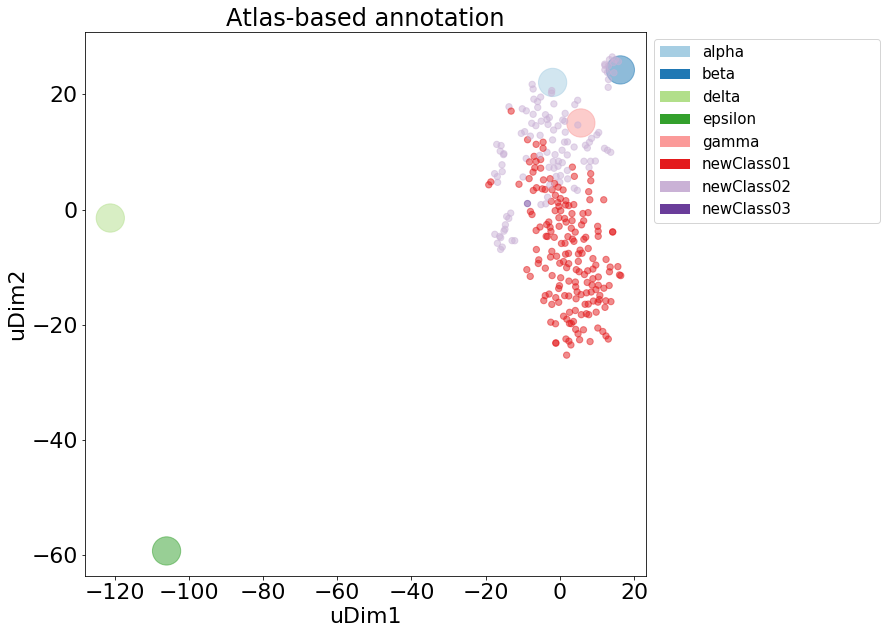

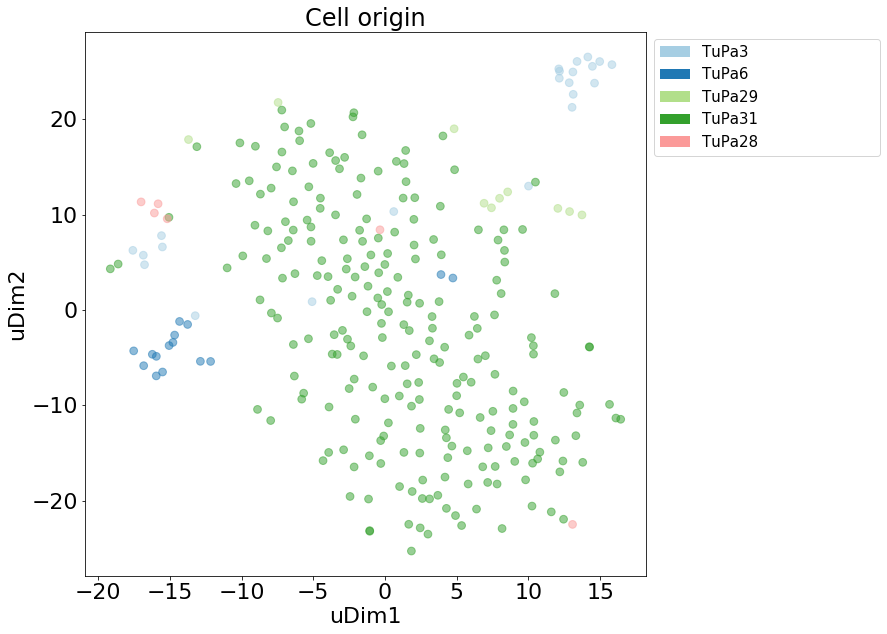

In [16]:
"""tsnedf_sub1.loc['delta','new_membership'] = 'delta'
tsnedf_sub1.loc['epsilon','new_membership'] = 'epsilon'
tsnedf_sub1.loc['gamma','new_membership'] = 'gamma'"""
imp.reload(sam)
sam.plot_tsnes(tsnedf_sub1,class_numbers_sub1,class_labels_sub1,weights,TuPa_meta_sub1,**kwds)

### doesn't work too great. Beta cells of TuPa3 are singled out, but annotation doesn't work too great, although we can see the bulk are probably gamma-like (cancer cells)

In [59]:
imp.reload(sam)
kwds['number_of_cells_per_type'] = 20
matrix_sub,annot,annotdict, AA_manual_meta_sub1,TuPa_meta_sub1 = sam.normmerge_twoCounttables_subsample(AA_counttable[endocrine_atlas_cells],
                                                                             AA_manual_meta.loc[endocrine_atlas_cells], 
                                                                             TuPa_counttable[endocrine_test_cells], 
                                                                             TuPa_meta.loc[endocrine_test_cells], **kwds)
matrix_feature_selected_sub = sam.feature_select_sub(matrix_sub.dropna(how='all',axis=1),annot,AA_manual_meta_sub1,**kwds)

-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5', 'ERCC-00002', 'ERCC-00003', 'ERCC-00004', 'ERCC-00009', 'ERCC-00012', 'ERCC-00013', 'ERCC-00014', 'ERCC-00016', 'ERCC-00017', 'ERCC-00019', 'ERCC-00022', 'ERCC-00024', 'ERCC-00025', 'ERCC-00028', 'ERCC-00031', 'ERCC-00033', 'ERCC-00034', 'ERCC-00035', 'ERCC-00039', 'ERCC-00040', 'ERCC-00041', 'ERCC-00042', 'ERCC-00043', 'ERCC-00044', 'ERCC-00046', 'ERCC-00048', 'ERCC-00051', 'ERCC-00053', 'ERCC-00054', 'ERCC-00057', 'ERCC-00058', 'ERCC-00059', 'ERCC-00060', 'ERCC-00061', 'ERCC-00062', 'ERCC-00067', 'ERCC-00069', 'ERCC-00071', 'ERCC-00073', 'ERCC-00074', 'ERCC-00075', 'ERCC-00076', 'ERCC-00077', 'ERCC-00078', 'ERCC-00079', 'ERCC-00081', 'ERCC-00083', 'ERCC-00084', 'ERCC-00085', 'ERCC-00086', 'ERCC-00092', 'ERCC-00095', 'ERCC-00096', 'ERCC-00097', 'ERCC-00098', 'ERCC-00099', 'ERCC-00104', 'ERCC-00108', 'ERCC-00109', 'ERCC-00111', 'ERCC-00112', 'ERCC-00113', 'ERCC-00116', 'ERCC-00117', 'ERCC-00

-------------------------------------------
Cell types in atlas:
['alpha' 'beta' 'delta' 'epsilon' 'gamma']
-------------------------------------------
Cell types in new data:
[nan]
-------------------------------------------
100
-------------------------------------------
Selected number of genes from atlas:
600
-------------------------------------------
Selected number of genes from new cells:
40
-------------------------------------------
Combined total of selected genes:
636
-------------------------------------------


In [60]:
kwds['resolution_parameter'] = respar = .001
imp.reload(sam)
annotdict
inverted_dict = dict([[v,k] for k,v in annotdict.items()])
inverted_dict
annot_str = list(map(inverted_dict.get, annot))

tsnedf_sub1SU, class_numbers_sub1SU,class_labels_sub1SU = sam.semiAnnotate_subsample(
                                                                                                matrix_feature_selected_sub,     
                                                                                                  annot_str,
                                                                                                   AA_manual_meta_sub1,
                                                                                                    TuPa_meta_sub1,**kwds)

-------------------------------------------
performing UNweighted PCA
-------------------------------------------
perfoming tSNE
tSNE done.
-------------------------------------------


In [184]:
class_numbers_sub1SU
TuPa_meta_sub1

,nGene,nReads,orig.ident,Tumor,Plate,Well,S,percent.mito,percent.ERCC,percent.ribo,res.1,tSNE_1,tSNE_2,celltypes,n_reads,new_class
TuPa3_Plate1_C6_S000,3023,682274,TuPa3,TuPa3,Plate1,C6,S000,0.292874,0.378923,0.010619,13,-9.621450,-12.914508,NaN,682274,alpha
TuPa3_Plate1_C7_S000,2019,414869,TuPa3,TuPa3,Plate1,C7,S000,0.286934,0.424213,0.002586,13,-8.370445,-13.323031,NaN,414839,gamma
TuPa3_Plate1_D2_S000,4483,2247495,TuPa3,TuPa3,Plate1,D2,S000,0.100204,0.076448,0.023980,13,-10.628248,-12.836204,NaN,2247492,alpha
TuPa3_Plate1_E12_S000,2865,219284,TuPa3,TuPa3,Plate1,E12,S000,0.094722,0.209035,0.050423,13,-10.397382,-13.208726,NaN,219261,gamma
TuPa3_Plate1_G8_S000,2129,141704,TuPa3,TuPa3,Plate1,G8,S000,0.253903,0.559442,0.011249,13,-9.209332,-13.083287,NaN,141680,alpha
TuPa3_Plate1_H3_S000,1836,114663,TuPa3,TuPa3,Plate1,H3,S000,0.268735,0.546720,0.013841,13,-9.525321,-13.092339,NaN,114663,gamma
TuPa3_Plate1_C4_S000,1865,613166,TuPa3,TuPa3,Plate1,C4,S000,0.003803,0.140170,0.029318,9,-2.264362,-6.382170,NaN,613166,alpha
TuPa3_Plate1_G5_S000,3458,273128,TuPa3,TuPa3,Plate1,G5,S000,0.328201,0.230615,0.024216,13,-9.718980,-12.842013,NaN,273106,beta
TuPa3_Plate1_E1_S000,2239,138369,TuPa3,TuPa3,Plate1,E1,S000,0.128324,0.426345,0.045422,13,-9.459346,-13.062536,NaN,138368,gamma
TuPa3_Plate1_C1_S000,3305,824852,TuPa3,TuPa3,Plate1,C1,S000,0.115982,0.129998,0.025046,13,-10.422881,-12.923289,NaN,824805,alpha


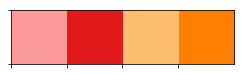

In [402]:

sns.palplot(sns.color_palette('Paired',11)[4:8])

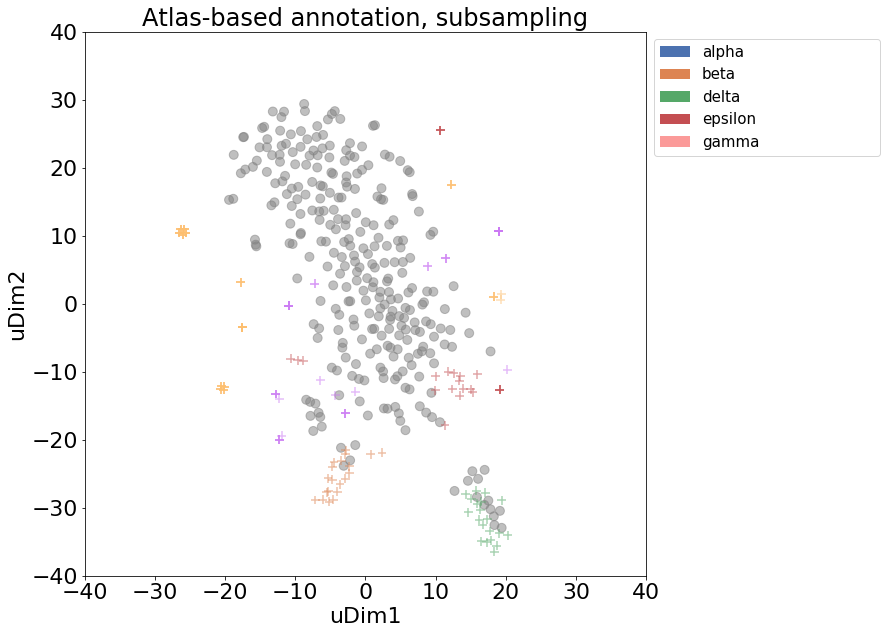

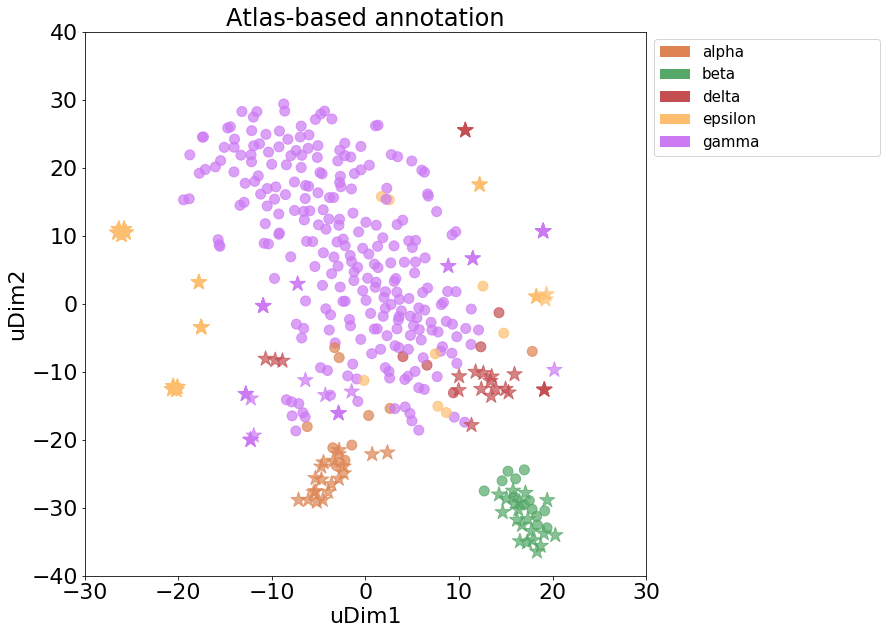

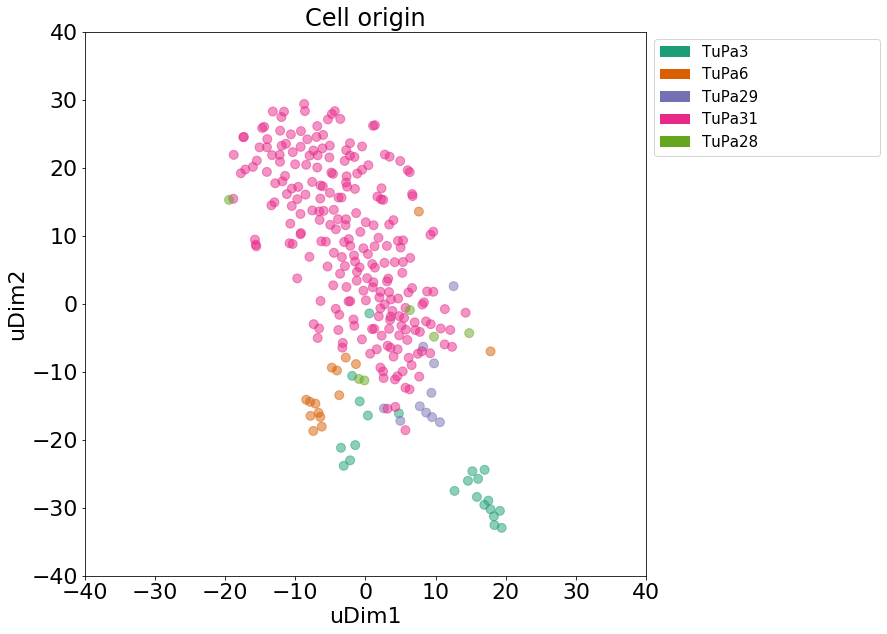

In [415]:
imp.reload(sam)
sam.plot_tsnes_subsample(tsnedf_sub1SU,
                                                 class_numbers_sub1SU,
                                                    class_labels_sub1SU,
                                                        np.ones(len(tsnedf_sub1SU)),
                                                            TuPa_meta_sub1,
                                                                newlut2,**kwds)

In [163]:
tsnedf.loc[endocrine_test_cells,'new_membership'] = tsnedf_sub1SU.loc[endocrine_test_cells,'new_membership']

In [410]:
newlut2.keys()

dict_keys(['acinar', 'alpha', 'beta', 'delta', 'ductal', 'endothelial', 'epsilon', 'gamma', 'mesenchymal', 'stellate', 'newClass01', 'newClass02', 'newClass03'])

ValueError: 'c' argument must either be valid as mpl color(s) or as numbers to be mapped to colors. Here c = acinar                    (0.6509803921568628, 0.807843137254902, 0.8901...
alpha                     (0.12156862745098039, 0.47058823529411764, 0.7...
beta                      (0.6980392156862745, 0.8745098039215686, 0.541...
delta                        (0.2, 0.6274509803921569, 0.17254901960784313)
ductal                         (0.984313725490196, 0.6039215686274509, 0.6)
endothelial               (0.8901960784313725, 0.10196078431372549, 0.10...
epsilon                   (0.792156862745098, 0.6980392156862745, 0.8392...
gamma                     (0.41568627450980394, 0.23921568627450981, 0.6...
mesenchymal               (0.6313725490196078, 0.3951557093425605, 0.095...
stellate                  (0.8572856593617839, 0.7257977700884274, 0.447...
TuPa1_Plate2_B10_S000     (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate2_G3_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate1_D8_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate1_B5_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate1_F11_S000     (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate2_C7_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate2_H5_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate2_B3_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate2_F3_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate1_E3_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate2_B8_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate2_D2_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate1_B8_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate2_A9_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate1_G2_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate2_C11_S000     (0.8572856593617839, 0.7257977700884274, 0.447...
TuPa1_Plate2_B1_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate2_B4_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate2_A10_S000     (0.6313725490196078, 0.3951557093425605, 0.095...
TuPa1_Plate2_E2_S000      (0.6313725490196078, 0.3951557093425605, 0.095...
                                                ...                        
TuPa28_Plate1_L7_S264     (0.8572856593617839, 0.7257977700884274, 0.447...
TuPa28_Plate1_M9_S289     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_I2_S190     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_P16_S65     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_E19_S115    (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_K8_S242     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_C11_S61     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_B14_S41     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_G21_S163                                                  NaN
TuPa28_Plate1_G5_S147     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_O11_S37     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_B5_S32      (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_A13_S17     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_G3_S145     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_H4_S169     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_N16_S19     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_K18_S252    (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_G22_S164                                                  NaN
TuPa28_Plate1_A17_S21     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_F21_S140                                                  NaN
TuPa28_Plate1_H1_S166     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_B17_S44     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_C23_S73                                                   NaN
TuPa28_Plate1_J11_S222    (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_A19_S23     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_J7_S218     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_M6_S286     (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_H14_S179    (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_D1_S74      (0.4615916955017304, 0.7748558246828146, 0.729...
TuPa28_Plate1_J17_S228    (0.4615916955017304, 0.7748558246828146, 0.729...
Name: new_membership, Length: 1805, dtype: object.

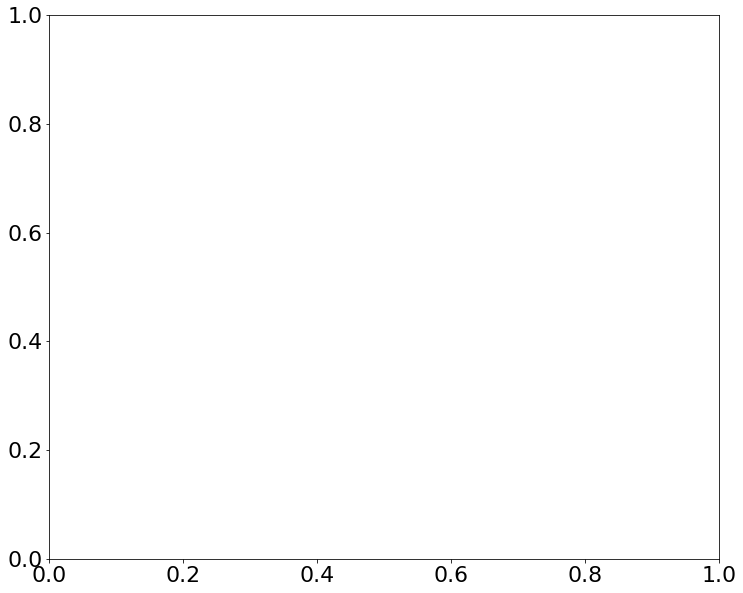

In [409]:
if len(class_labels)>8:
    if (len(class_labels)-8) % 2 == 0:
        added_colors = sns.color_palette('BrBG',len(class_labels)-8)
    else:
        all_colors = sns.color_palette('BrBG',len(class_labels)-7)
        mid = round((len(all_colors)-1)/2)
        added_colors = all_colors[:mid]+all_colors[mid+1:]
    values = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]+added_colors
else:
    values = sns.color_palette('Paired',len(class_labels))
newlut = dict(zip(class_numbers,values))
newlut2 = dict(zip(class_labels,values))
newcolor = tsnedf['new_membership'].map(newlut2)


f,ax = plt.subplots(figsize=(12,10))
tsnedf.plot.scatter('uDim1','uDim2',s=weights*40
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,class_labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Atlas-based annotation')
#plt.xlim(right=65)
#plt.ylim(bottom=-60)
plt.gcf().subplots_adjust(left=.1,right=0.75)

# look into the blood cells

In [91]:
cells_for_subclustering = tsnedf[(tsnedf['uDim1']>-40)&(tsnedf['uDim1']<10)&(tsnedf['uDim2']>=1)].index
cells_for_subclustering2 = tsnedf[(tsnedf['uDim1']>-40)&(tsnedf['uDim1']<-2)&(tsnedf['uDim2']<1)&(tsnedf['uDim2']>-15)].index
cells_for_subclustering = list(cells_for_subclustering)+list(cells_for_subclustering2)

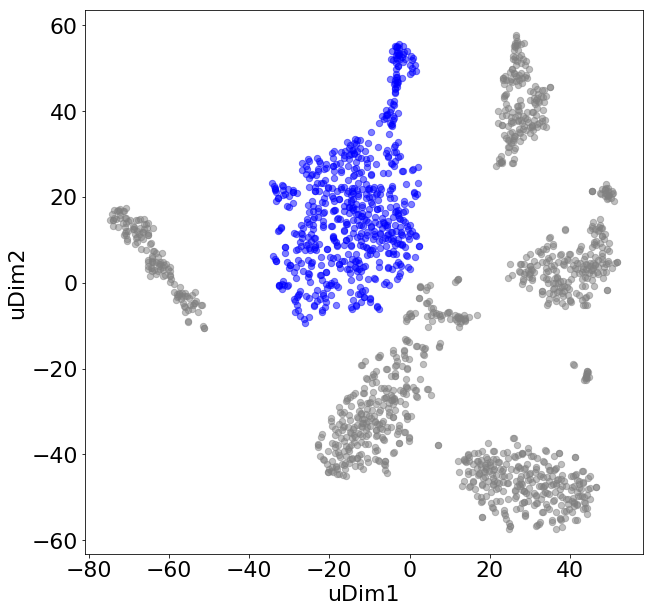

In [92]:
f,ax = plt.subplots(figsize=(10,10))
tsnedf[~tsnedf.index.isin(cells_for_subclustering)].plot.scatter('uDim1','uDim2',s=40
                    ,alpha=.5,color='gray',ax=ax)
tsnedf.loc[cells_for_subclustering].plot.scatter('uDim1','uDim2',s=40
                    ,alpha=.5,color='b',ax=ax)

In [136]:
atlas_metadata

,number_of_cells,celltypes
Stitzel_2016_Acinar,15,Stitzel_2016_Acinar
Stitzel_2016_Alpha,138,Stitzel_2016_Alpha
Stitzel_2016_Beta,168,Stitzel_2016_Beta
Stitzel_2016_Delta,16,Stitzel_2016_Delta
Stitzel_2016_Ductal,12,Stitzel_2016_Ductal
Stitzel_2016_Gamma/PP,12,Stitzel_2016_Gamma/PP
Stitzel_2016_Stellate,9,Stitzel_2016_Stellate
Baron_2016_acinar,956,Baron_2016_acinar
Baron_2016_activated_stellate,232,Baron_2016_activated_stellate
Baron_2016_alpha,2042,Baron_2016_alpha


In [145]:
baron = ['Baron_2016_macrophage','Baron_2016_t_cell']
zanini = ['Zanini_2018_pDC','Zanini_2018_plasmablast','Zanini_2018_classical monocyte']#Zanini_2018_pDC
atlas_metadata_select = atlas_metadata[(atlas_metadata['celltypes'].str.contains('Zanini'))|(atlas_metadata['celltypes'].isin(baron))]
atlas_metadata_select = atlas_metadata[(atlas_metadata['celltypes'].isin(zanini))|(atlas_metadata['celltypes'].isin(baron))]
atlas_metadata_select


,number_of_cells,celltypes
Baron_2016_macrophage,45,Baron_2016_macrophage
Baron_2016_t_cell,6,Baron_2016_t_cell
Zanini_2018_classical monocyte,872,Zanini_2018_classical monocyte
Zanini_2018_pDC,200,Zanini_2018_pDC
Zanini_2018_plasmablast,109,Zanini_2018_plasmablast


In [172]:
new_cells_subclustering = [f for f in cells_for_subclustering if f not in class_labels]
imp.reload(sam)
atlasgenes = 60
atlasweights = 20

keys = ['cell type column','number of features cell type','number of features new data'
        ,'weights_atlas_cells','timestamp','savedir']
values = ['celltypes',atlasgenes,10,atlasweights,date,savedir]
kwds = dict(zip(keys,values))
matrix,weights_sel, atlas_metadata_select,TuPa_meta_sub2 = sam.normmerge_twoCounttables(atlas_counttable,                     
                                                                             atlas_metadata_select, 
                                                                                TuPa_counttable[new_cells_subclustering], 
                                                                                    TuPa_meta.loc[new_cells_subclustering], **kwds)
matrix_feature_selected_sub2 = sam.feature_select(matrix.dropna(how='all',axis=1),atlas_metadata_select,**kwds)

-------------------------------------------
genes to be removed from counttable:
[]
-------------------------------------------


/home/bojk/Data/minimeta_pyfiles/semiAnnotate_main.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  metadata['n_reads'] = counttable.loc[genes_in].sum()


-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5', 'ACEA_U3', 'CoTC_ribozyme', 'CPEB3_ribozyme', 'CTA-280A3__B-2', 'DAOA-AS1_2', 'DLEU2_4', 'DLEU2_6', 'DLG2-AS1_1', 'DLG2-AS1_2', 'Evf-2_5p', 'FAM13A-AS1_2', 'FTX_1', 'FTX_4', 'GNAS-AS1_2', 'H19_3', 'Hammerhead_HH10', 'Hammerhead_HH9', 'HOXA11-AS1_5', 'HOXB13-AS1_1', 'HOXB13-AS1_2', 'Metazoa_SRP', 'Metazoa_SRP-1', 'Metazoa_SRP-10', 'Metazoa_SRP-100', 'Metazoa_SRP-101', 'Metazoa_SRP-102', 'Metazoa_SRP-103', 'Metazoa_SRP-104', 'Metazoa_SRP-105', 'Metazoa_SRP-106', 'Metazoa_SRP-107', 'Metazoa_SRP-108', 'Metazoa_SRP-109', 'Metazoa_SRP-11', 'Metazoa_SRP-110', 'Metazoa_SRP-111', 'Metazoa_SRP-112', 'Metazoa_SRP-113', 'Metazoa_SRP-114', 'Metazoa_SRP-115', 'Metazoa_SRP-116', 'Metazoa_SRP-117', 'Metazoa_SRP-118', 'Metazoa_SRP-119', 'Metazoa_SRP-12', 'Metazoa_SRP-120', 'Metazoa_SRP-121', 'Metazoa_SRP-122', 'Metazoa_SRP-123', 'Metazoa_SRP-124', 'Metazoa_SRP-125', 'Metazoa_SRP-126', 'Metazoa_SRP-127', 'Met

-------------------------------------------
Cell types in atlas:
['Baron_2016_macrophage' 'Baron_2016_t_cell'
 'Zanini_2018_classical monocyte' 'Zanini_2018_pDC'
 'Zanini_2018_plasmablast']
-------------------------------------------
Cell types in new data:
[nan]
-------------------------------------------
-------------------------------------------
Selected number of genes from atlas:
300
-------------------------------------------
Selected number of genes from new cells:
10
-------------------------------------------
Combined total of selected genes:
309
-------------------------------------------


In [204]:
imp.reload(sam)
kwds['threshold_neigborhood'] = thresn = .8
kwds['n_pcs'] = n_pcs = 20 
kwds['resolution_parameter'] = respar = .015
kwds['self_edging'] = False
kwds['select_features']=False

tsnedf_sub2, class_numbers_sub2,class_labels_sub2,distmat = sam.semiAnnotate_to_pca_to_tsnedf(matrix_feature_selected_sub2,
                                                                               weights_sel,
                                                                               atlas_metadata_select,
                                                                               TuPa_meta_sub2,**kwds)

-------------------------------------------
performing UNweighted PCA
-------------------------------------------
perfoming tSNE
tSNE done.
-------------------------------------------


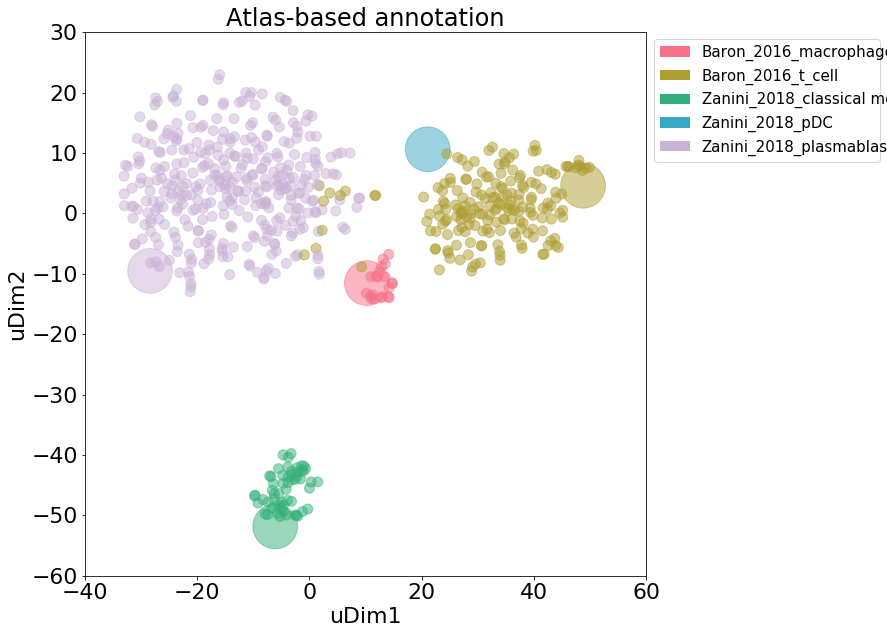

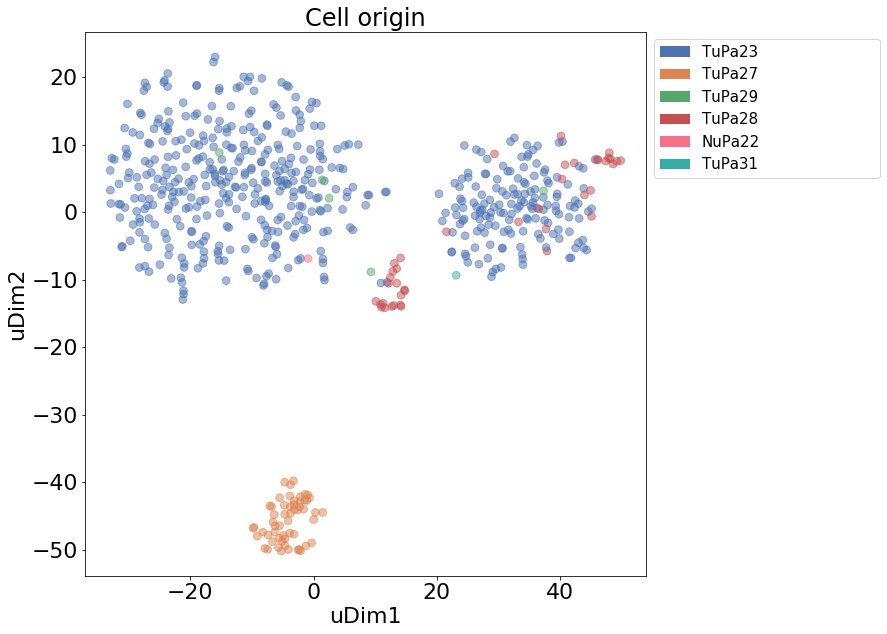

In [414]:
imp.reload(sam)
sam.plot_tsnes(tsnedf_sub2,class_numbers_sub2,class_labels_sub2,weights_sel,TuPa_meta_sub2,newlut2,**kwds)

In [164]:
tsnedf.loc[new_cells_subclustering,'new_membership'] = tsnedf_sub2.loc[new_cells_subclustering,'new_membership']

In [214]:
a = [1,2,3,4,5,6]
a[1:6:1]

[2, 3, 4, 5, 6]

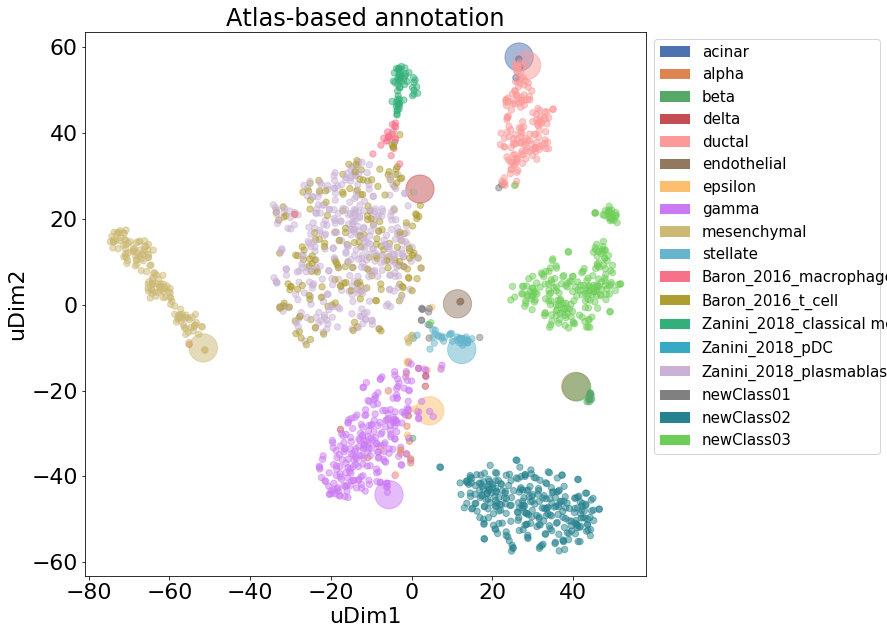

In [413]:
class_label_all = class_labels[:10]+class_labels_sub2+class_labels[10:]

if len(class_label_all)>10:
    if (len(class_label_all)-10) % 2 == 0:
        added_colors = sns.color_palette('husl',len(class_label_all)-10-3)+sns.color_palette('viridis',8)[0:8:3]
    else:
        all_colors = sns.color_palette('husl',len(class_label_all)-9)
        mid = round((len(all_colors)-1)/2)
        added_colors = all_colors[:mid]+all_colors[mid+1:]
    values = sns.color_palette('deep', 10)+added_colors
else:
    values = sns.color_palette('Paired',len(class_labels))
#newlut = dict(zip(class_numbers,values))
newlut2 = dict(zip(class_label_all,values))

newlut2['ductal'] = sns.color_palette('Paired',11)[4]
newlut2['epsilon'] = sns.color_palette('Paired',11)[6]
newlut2['newClass01'] = 'gray'
newlut2['gamma'] = newlut2['Zanini_2018_plasmablast']
newlut2['Zanini_2018_plasmablast'] = sns.color_palette('Paired',11)[8]
newcolor = tsnedf['new_membership'].map(newlut2)


f,ax = plt.subplots(figsize=(12,10))
tsnedf.plot.scatter('uDim1','uDim2',s=weights*40
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut2.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,class_label_all,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Atlas-based annotation')
#plt.xlim(right=65)
#plt.ylim(bottom=-60)
plt.gcf().subplots_adjust(left=.1,right=0.75)

f.savefig(savedir+date+'/custom_annotation_tSNE.png')
f.savefig(savedir+date+'/custom_annotation_tSNE.pdf')



In [452]:
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_manAnnot_top20'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanelSU20,roSE,coSE,genes_ODSU20,avgSU20 = sdot.make_dotplot(matrix_feature_selected,tsnedf,20,**kw)

/home/bojk/Data/minimeta_pyfiles/semiAnnotate_dotplot.py:171: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(xgrid,np.ones(len(xgrid))*i,s=np.log2(temp).multiply(70),alpha=.8)
/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [453]:
genes_ODSU20

,acinar,alpha,beta,delta,ductal,endothelial,epsilon,gamma,mesenchymal,stellate,newClass03,Baron_2016_t_cell,Zanini_2018_plasmablast,Baron_2016_macrophage,newClass01,Zanini_2018_classical monocyte,newClass02
0,CTRB2,GCG,INS,SST,TRPV6,SELE,GHRL,FAM151A,SFRP2,HIGD1B,PGC,CD8A,FAM209A,HAMP,ZPBP2,GZMB,UGT2B11
1,REG3G,TRPA1,IAPP,LRFN5,SPRR2A,EMCN,BHMT,POPDC3,DPT,COX4I2,KRT5,CD5,HVCN1,MIR3939,DCC,FGR,FGB
2,PNLIPRP1,NDST3,ASB9,CALCA,KRTAP1-1,CDH5,CRYGC,NPFFR2,SFRP4,FOXS1,LEFTY1,PZP,ZNF296,F13A1,CNTN6,IL1RN,SERPIND1
3,REG1B,OPRM1,LRRTM3,CA10,APCS,ROBO4,OPRK1,SLC6A4,COL1A1,ANGPT4,CXCL17,GIMAP7,IL16,P2RY12,DPF1,CSF2RB,PENK
4,CPA2,SGCZ,DLK1,ADCYAP1,FRMD1,FCN3,OR2T8,ATP2B2,APOD,GPR20,KRT23,GSTM5,RASGRP2,CACNB4,NCAPG,CD38,SLC17A1
5,REG3A,SPOCK3,SLC2A2,ZSCAN5B,SERPINA5,MMRN2,TAS2R5,NPAS4,RSPO3,CSPG4,CTSE,LAIR2,POU3F1,IL1A,GRIA1,CFP,SULT1B1
6,CTRB1,GABRA1,KLHL1,GRM7,NR1H4,PLP1,NBPF7,BVES-AS1,COL1A2,P2RX3,CLDN18,CORO6,PCDH10,CD300A,PYDC1,PTGER2,CARTPT
7,CPB1,C6orf58,ATXN8OS,EYS,SFRP5,KDR,GHRLOS,SPAG8,SHOX2,OR51E2,TFF1,PDE6G,TNR,PLCB2,CCDC168,GLT1D1,F7
8,CPA1,OR7D2,ACPP,DYDC1,CXCL6,CXorf36,NEUROG3,C4orf45,OSR1,TAC4,KRT6B,RASAL3,RCSD1,IL1B,BRS3,PTGFR,ANXA13
9,AQP8,ARMC4,KCNF1,AHSP,VTCN1,SLCO2A1,COL2A1,PCDHA8,SCARF2,NOTCH3,FUT6,ARHGAP15,PPP1R16B,HESX1,ITIH3,LSP1,C3orf80


In [222]:
TuPa_counttable_norm, TuPa_meta = sam.normalize_UMGs(TuPa_counttable,TuPa_meta)

-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5', 'ACEA_U3', 'CoTC_ribozyme', 'CPEB3_ribozyme', 'CTA-280A3__B-2', 'DAOA-AS1_2', 'DLEU2_4', 'DLEU2_6', 'DLG2-AS1_1', 'DLG2-AS1_2', 'Evf-2_5p', 'FAM13A-AS1_2', 'FTX_1', 'FTX_4', 'GNAS-AS1_2', 'H19_3', 'Hammerhead_HH10', 'Hammerhead_HH9', 'HOXA11-AS1_5', 'HOXB13-AS1_1', 'HOXB13-AS1_2', 'Metazoa_SRP', 'Metazoa_SRP-1', 'Metazoa_SRP-10', 'Metazoa_SRP-100', 'Metazoa_SRP-101', 'Metazoa_SRP-102', 'Metazoa_SRP-103', 'Metazoa_SRP-104', 'Metazoa_SRP-105', 'Metazoa_SRP-106', 'Metazoa_SRP-107', 'Metazoa_SRP-108', 'Metazoa_SRP-109', 'Metazoa_SRP-11', 'Metazoa_SRP-110', 'Metazoa_SRP-111', 'Metazoa_SRP-112', 'Metazoa_SRP-113', 'Metazoa_SRP-114', 'Metazoa_SRP-115', 'Metazoa_SRP-116', 'Metazoa_SRP-117', 'Metazoa_SRP-118', 'Metazoa_SRP-119', 'Metazoa_SRP-12', 'Metazoa_SRP-120', 'Metazoa_SRP-121', 'Metazoa_SRP-122', 'Metazoa_SRP-123', 'Metazoa_SRP-124', 'Metazoa_SRP-125', 'Metazoa_SRP-126', 'Metazoa_SRP-127', 'Met

In [223]:
np.log2(TuPa_counttable_norm+.01)

,TuPa1_Plate2_B10_S000,TuPa1_Plate2_G3_S000,TuPa1_Plate1_D8_S000,TuPa1_Plate1_B5_S000,TuPa1_Plate1_F11_S000,TuPa1_Plate2_C7_S000,TuPa1_Plate2_H5_S000,TuPa1_Plate2_B3_S000,TuPa1_Plate2_F3_S000,TuPa1_Plate1_E3_S000,...,TuPa28_Plate1_H1_S166,TuPa28_Plate1_B17_S44,TuPa28_Plate1_C23_S73,TuPa28_Plate1_J11_S222,TuPa28_Plate1_A19_S23,TuPa28_Plate1_J7_S218,TuPa28_Plate1_M6_S286,TuPa28_Plate1_H14_S179,TuPa28_Plate1_D1_S74,TuPa28_Plate1_J17_S228
A1BG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,22.876634,0.000000,0.000000,0.000000,0.000000,23.342410,0.000000,0.000000,20.347018,0.000000
A1BG-AS1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1CF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,37.864774,0.000000,0.000000,0.000000,101.495006,519.899140,691.450265,125.252055,0.000000,312.856852
A2M,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2M-AS1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2ML1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2ML1-AS1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2ML1-AS2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2MP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A3GALT2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# get averages per enge class
# get atlas averages of used atlases
# cell classes to show:
# alpha beta gamma delta epsilon
# newclass02,newclass03
# macrophage, tcell, monocyte, plasmablast

# genes:

In [229]:
cells = [];classlist = []
for classes in tsnedf['new_membership'].unique():
    classlist.append(classes)
    cells.append(list(tsnedf[10:][tsnedf[10:]['new_membership']==classes].index))
celldict = dict(zip(classlist,cells))

In [233]:
list(celldict.keys())


TypeError: unhashable type: 'list'

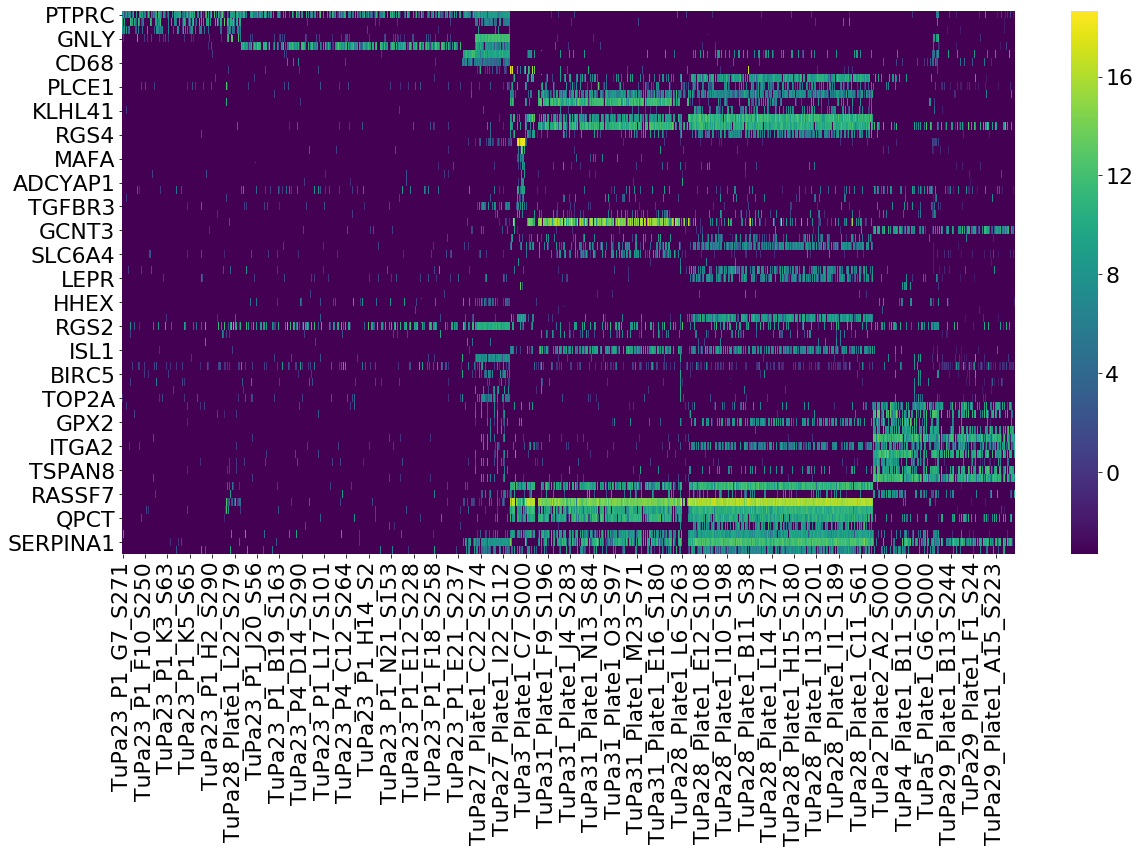

In [460]:
classes = ['Baron_2016_t_cell','Zanini_2018_plasmablast','Baron_2016_macrophage','Zanini_2018_classical monocyte'
                   ,'alpha','beta','gamma','delta','epsilon','newClass02','newClass03']
classes_blood = classes[0:4]
celllist_sel = [celldict[f] for f in ['newClass03','newClass02','gamma']]
celllist = [celldict[f] for f in classes]
celllist_blood = [celldict[f] for f in classes_blood]
cellnums = [len(f) for f in celllist]
cellnums_sel = [len(f) for f in celllist_sel]
cellnums_blood = [len(f) for f in celllist_blood]
flat_list = [item for sublist in celllist for item in sublist]
flat_list_sel = [item for sublist in celllist_sel for item in sublist]
flat_list_blood = [item for sublist in celllist_blood for item in sublist]

blood_all = ['PTPRC','CD2','CD3E','GNLY','MS4A1','CD14','CD68']#,'PTPR5','FCGRA1'
alpha = ['GCG','LOXL4','PLCE1','IRX2','GC','KLHL41','CRYBA2','TM4SF4','RGS4']
beta = ['INS','IAPP','MAFA','NPTX2','DLK1','ADCYAP1','PFKFB2','PDX1','TGFBR3','SYT13']
delta = ['SST','PRG4','LEPR','RBP4','BCHE','HHEX','FRZB','PCSK1','RGS2','GABRG2']
gamma = ['PPY','GCNT3','ID4','KCNH6','SLC6A4']
epsilon = ['GHRL','ISL1']
adino = ['LAMC2','CTSE','GPX2','LGALS4','GPRC5A','ITGA2','AGR2','COL17A1','TSPAN8','GPRC5A']#,'MMP14','CEACAM7'
islet = ['SCG2','RASSF7','TTR','PCSK2','QPCT','FGB','PTPRN2','SERPINA1','ARF3'] #,'SGNE1','PEX7','INSM1',
cancer_markers = ['MKI67','MCM5','BIRC5','BUB1','CDK1','TOP2A']
cancer_markers_all = cancer_markers+adino+islet
all_markers = blood_all+alpha+beta+gamma+delta+epsilon+cancer_markers_all

markers_sel = adino+islet+['PPY']
markerlens_sel = np.cumsum([len(adino),len(islet),1])
markerlens = np.cumsum([len(f) for f in [blood_all]+[alpha]+[beta]+[gamma]+[delta]+[epsilon]+[cancer_markers]+[adino]+[islet]])
f = plt.figure(figsize=(20,10))
sns.heatmap(np.log2(TuPa_counttable_norm.loc[all_markers,flat_list]+.1).dropna(how='all'),cmap='viridis')
f.savefig(savedir+date+'/heatmap_colorbar.pdf')

In [461]:
date

'20190821171330'

In [451]:
f = plt.figure(figsize=(30,30))

gs = gridspec.GridSpec(60,1)

ax1  = f.add_subplot(gs[2:-2,0])
sns.heatmap(np.log2(TuPa_counttable_norm.loc[all_markers,flat_list]+.1).dropna(how='all'),
            cmap='viridis',ax=ax1,cbar=False,yticklabels=True)
for i in range(len(cumsum)-1):
    ax1.axvline(cumsum[i],color='white')
for i in range(len(markerlens)-1):
    ax1.axhline(markerlens[i],color='white')
ax1.set_xticks([]);ax1.set_xlabel('')

ax2 = f.add_subplot(gs[:2,0]) #cell classes
color = tsnedf.loc[flat_list]['new_membership'].map(newlut2)
for x in classes:
    y = newlut2[x]
    plt.bar(0,0,color=y,label=x,width=1)
plt.legend(bbox_to_anchor=(1.02, -6, 0.2, .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.,fontsize=20)

plt.bar(list(range(len(flat_list))),np.ones(len(flat_list)),color=color,width=1)
plt.xticks([]);plt.yticks([])
plt.xlim(-.5,len(flat_list)-.5);plt.ylim(0,1)
ax2.set_xticks([]);ax2.set_xlabel('')
ax2.set_yticks([]);ax2.set_ylabel('')

ax3 = f.add_subplot(gs[-2:,0]) # tupa's
keys = TuPa_meta.loc[flat_list,'Tumor'].unique();values = sns.color_palette('Paired',len(keys))
lutTupa = dict(zip(keys,values))
color = TuPa_meta.loc[flat_list]['Tumor'].map(lutTupa)
for x,y in lutTupa.items():
    plt.bar(0,0,color=y,label=x,width=1)
plt.legend(bbox_to_anchor=(1.02, 6
                           , .15, .102), loc=2,
           ncol=1, mode="expand", borderaxespad=0.,fontsize=20)

plt.bar(list(range(len(flat_list))),np.ones(len(flat_list)),color=color,width=1)
plt.xticks([]);plt.yticks([])
plt.xlim(-.5,len(flat_list)-.5);plt.ylim(0,1)

ax3.scatter(1,1)
ax3.set_xticks([]);ax3.set_xlabel('')
ax3.set_yticks([]);ax3.set_ylabel('')

plt.gcf().subplots_adjust(left=.1,top=.95,right=.8,bottom=.03)
f.savefig(savedir+date+'/heatmap_test.png')
f.savefig(savedir+date+'/heatmap_test.pdf')
plt.close(f)

In [450]:
f = plt.figure(figsize=(20,10))

gs = gridspec.GridSpec(60,1)

ax1  = f.add_subplot(gs[2:-2,0])
sns.heatmap(np.log2(TuPa_counttable_norm.loc[blood_all,flat_list_blood]+.1).dropna(how='all'),
            cmap='viridis',ax=ax1,cbar=False,yticklabels=True)
for i in range(len(cellnums_blood)-1):
    ax1.axvline(np.cumsum(cellnums_blood)[i],color='white')
"""for i in range(len(markerlens)-1):
    ax1.axhline(markerlens[i],color='white')"""
ax1.set_xticks([]);ax1.set_xlabel('')

ax2 = f.add_subplot(gs[:2,0]) #cell classes
color = tsnedf.loc[flat_list_blood]['new_membership'].map(newlut2)
for x in classes:
    y = newlut2[x]
    plt.bar(0,0,color=y,label=x,width=1)
plt.legend(bbox_to_anchor=(1.02, -15, 0.2, .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.,fontsize=20)

plt.bar(list(range(len(flat_list_blood))),np.ones(len(flat_list_blood)),color=color,width=1)
plt.xticks([]);plt.yticks([])
plt.xlim(-.5,len(flat_list_blood)-.5);plt.ylim(0,1)
ax2.set_xticks([]);ax2.set_xlabel('')
ax2.set_yticks([]);ax2.set_ylabel('')

ax3 = f.add_subplot(gs[-2:,0]) # tupa's
keys = TuPa_meta.loc[flat_list_blood,'Tumor'].unique();values = sns.color_palette('Paired',len(keys))
lutTupa = dict(zip(keys,values))
color = TuPa_meta.loc[flat_list_blood]['Tumor'].map(lutTupa)
for x,y in lutTupa.items():
    plt.bar(0,0,color=y,label=x,width=1)
plt.legend(bbox_to_anchor=(1.02, 10
                           , .15, .102), loc=2,
           ncol=1, mode="expand", borderaxespad=0.,fontsize=20)

plt.bar(list(range(len(flat_list_blood))),np.ones(len(flat_list_blood)),color=color,width=1)
plt.xticks([]);plt.yticks([])
plt.xlim(-.5,len(flat_list_blood)-.5);plt.ylim(0,1)

ax3.scatter(1,1)
ax3.set_xticks([]);ax3.set_xlabel('')
ax3.set_yticks([]);ax3.set_ylabel('')

plt.gcf().subplots_adjust(left=.1,top=.95,right=.7,bottom=.03)
f.savefig(savedir+date+'/heatmap_blood_test.png')
f.savefig(savedir+date+'/heatmap_blood_test.pdf')
plt.close(f)

In [417]:
f = plt.figure(figsize=(30,9))

gs = gridspec.GridSpec(60,1)

ax1  = f.add_subplot(gs[4:-4,0])
sns.heatmap(np.log2(TuPa_counttable_norm.loc[markers_sel,flat_list_sel]+.1).dropna(how='all')
                                    ,cmap='viridis',ax=ax1,cbar=False,yticklabels=True)
for i in range(len(cellnums_sel)-1):
    ax1.axvline(np.cumsum(cellnums_sel)[i],color='white')
for i in range(len(markerlens_sel)-1):
    ax1.axhline(markerlens_sel[i],color='white')
ax1.set_xticks([]);ax1.set_xlabel('')

ax2 = f.add_subplot(gs[:4,0]) #cell classes
color = tsnedf.loc[flat_list_sel]['new_membership'].map(newlut2)
for x in ['gamma','newClass02','newClass03']:
    y = newlut2[x]
    plt.bar(0,0,color=y,label=x,width=1)
plt.legend(bbox_to_anchor=(1.02, -6, 0.2, .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.,fontsize=20)

plt.bar(list(range(len(flat_list_sel))),np.ones(len(flat_list_sel)),color=color,width=1)
plt.xticks([]);plt.yticks([])
plt.xlim(-.5,len(flat_list_sel)-.5);plt.ylim(0,1)
ax2.set_xticks([]);ax2.set_xlabel('')
ax2.set_yticks([]);ax2.set_ylabel('')

ax3 = f.add_subplot(gs[-4:,0]) # tupa's
keys = TuPa_meta.loc[flat_list_sel,'Tumor'].unique();values = sns.color_palette('Paired',len(keys))
lutTupa = dict(zip(keys,values))
color = TuPa_meta.loc[flat_list_sel]['Tumor'].map(lutTupa)
for x,y in lutTupa.items():
    plt.bar(0,0,color=y,label=x,width=1)
plt.legend(bbox_to_anchor=(1.02, 6
                           , .15, .102), loc=2,
           ncol=1, mode="expand", borderaxespad=0.,fontsize=20)

plt.bar(list(range(len(flat_list_sel))),np.ones(len(flat_list_sel)),color=color,width=1)
plt.xticks([]);plt.yticks([])
plt.xlim(-.5,len(flat_list_sel)-.5);plt.ylim(0,1)

ax3.scatter(1,1)
ax3.set_xticks([]);ax3.set_xlabel('')
ax3.set_yticks([]);ax3.set_ylabel('')

gs.update(hspace=2)
plt.gcf().subplots_adjust(left=.1,top=.95,right=.8)
f.savefig(savedir+date+'/heatmap_sel_test.png')
f.savefig(savedir+date+'/heatmap_sel_test.pdf')
plt.close(f)

In [267]:
len(TuPa_meta.loc[flat_list,'Tumor'].unique())



11

In [454]:
def cellTypeOccurrence(tsnedf,metadf):
    tsnedf['Tumor'] = metadf['Tumor']
    tsnedf['count'] = 1
    counts = pd.pivot_table(tsnedf,index='new_membership',columns='Tumor',values='count',aggfunc=np.sum)
    return counts

In [455]:
counts_normal = cellTypeOccurrence(tsnedf,TuPa_meta)

In [459]:
counts_normal.fillna(0).astype(int).to_csv(savedir+date+'/tumorSample_Class_relationship.csv')